![](images/EscUpmPolit_p.gif "UPM")

# Course Notes for Learning Intelligent Systems

Department of Telematic Engineering Systems, Universidad Politécnica de Madrid, © Carlos A. Iglesias

## [Introduction to Machine Learning II](3_0_0_Intro_ML_2.ipynb)

# Introduction SVM 

In this notebook we are going to train a classifier with the preprocessed Titanic dataset. 

We are going to use the dataset we obtained in the [pandas munging notebook](3_3_Data_Munging_with_Pandas.ipynb) for simplicity. You can try some of the techniques learnt in the previous notebook.

## Load and clean

In [ ]:
# General import and load data
import pandas as pd
import numpy as np
import os
import re

from pandas import Series, DataFrame

# Training and test spliting
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Estimators
from sklearn import tree

# Evaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)


# if matplotlib is not set inline, you will not see plots
#alternatives auto gtk gtk2 inline osx qt qt5 wx tk
#%matplotlib auto
#%matplotlib qt
%matplotlib inline
%run plot_learning_curve
sns.set()

ERROR:root:File `'plot_learning_curve.py'` not found.


In [ ]:
#We get a URL with raw content (not HTML one)
url="https://raw.githubusercontent.com/gsi-upm/sitc/master/ml2/data-titanic/train.csv"
df = pd.read_csv(url)
df.head()


#Fill missing values
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Sex'].fillna('male', inplace=True)
df['Embarked'].fillna('S', inplace=True)

# Encode categorical variables
df['Age'] = df['Age'].fillna(df['Age'].median())
df.loc[df["Sex"] == "male", "Sex"] = 0
df.loc[df["Sex"] == "female", "Sex"] = 1
df.loc[df["Embarked"] == "S", "Embarked"] = 0
df.loc[df["Embarked"] == "C", "Embarked"] = 1
df.loc[df["Embarked"] == "Q", "Embarked"] = 2

# Drop colums
df.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

#Show proprocessed df
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0


In [ ]:
#Check types are numeric
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object

We have still two columns as objects, so we change the type.

In [ ]:
df['Sex'] = df['Sex'].astype(np.int64)
df['Embarked'] = df['Embarked'].astype(np.int64)
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
dtype: object

In [ ]:
#Check there are not missing values
df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Embarked       False
dtype: bool

# Train and test splitting

We use the same techniques we applied in the Iris dataset. 

Nevertheless, we need to remove the column 'Survived' 

In [ ]:
# Features of the model
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# Transform dataframe in numpy arrays
X = df[features].values
y = df['Survived'].values



# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# Preprocess: normalize
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# Define model

In [ ]:

types_of_kernels = ['linear', 'rbf', 'poly']

kernel = types_of_kernels[0]
gamma = 3.0

# Create kNN model
model = SVC(kernel=kernel, probability=True, gamma=gamma)

# Train and evaluate

In [ ]:
#This step will take some time 
# Train - This is not needed if you use K-Fold

model.fit(X_train, y_train)

predicted = model.predict(X_test)
expected = y_test

In [ ]:
# Accuracy
metrics.accuracy_score(expected, predicted)

0.8116591928251121

Ok, we get around 82% of accuracy! (results depend on the splitting)

## Null accuracy

We can evaluate the accuracy if the model always predict the most frequent class, following this [refeference](http://blog.kaggle.com/2015/10/23/scikit-learn-video-9-better-evaluation-of-classification-models/).

In [ ]:
# Count number of samples per class
s_y_test = Series(y_test)
s_y_test.value_counts()

0    134
1     89
dtype: int64

In [ ]:
# Mean of ones
y_test.mean()

0.3991031390134529

In [ ]:
# Mean of zeros
1 - y_test.mean() 


0.600896860986547

In [ ]:
# Calculate null accuracy (binary classification coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.600896860986547

In [ ]:
# Calculate null accuracy (multiclass classification)
s_y_test.value_counts().head(1) / len(y_test)

0    0.600897
dtype: float64

So, since our accuracy was 0.82 is better than the null accuracy.

## Confussion matrix and F-score

We can obtain more information from the confussion matrix and the metric F1-score.
In a confussion matrix, we can see:

||**Predicted**: 0| **Predicted: 1**|
|---------------------------|
|**Actual: 0**| TN | FP |
|**Actual: 1**| FN|TP|

* **True negatives (TN)**: actual negatives that were predicted as negatives
* **False positives (FP)**: actual negatives that were predicted as positives
* **False negatives (TN)**: actual positives that were predicted as negatives
* **True negatives (TN)**: actual positives that were predicted as posiives

We can calculate several metrics from the confussion matrix

* **Recall** (also called *sensitivity*): when the actual value is positive, how often the prediction is correct? 
(TP / (TP + FN))
* **Specificity**: when the actual value is negative, how often the prediction is correct? (TN / (TN + FP))
* **False Positive Rate**: when the actual value is negative, how often the prediction is incorrect? (FP / (TN + FP))
* **Precision**: when a positive value is predicted, how many times is correct? (TP / (TP + FP)
A good metric is F1-score: 2TP / (2TP + FP + FN)

In [ ]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[115  19]
 [ 23  66]]


In [ ]:
# Report
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       134
           1       0.78      0.74      0.76        89

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



## ROC (Receiver Operating Characteristic ) and AUC (Area Under the Curve)

The [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)  curve illustrates the performance of a binary classifier system as its discrimination threshold is varied.

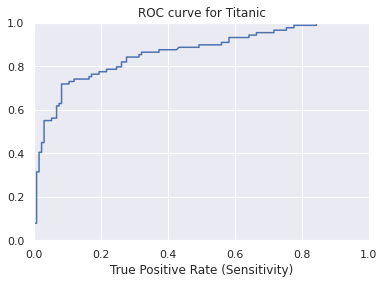

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic')
plt.xlabel('False Positive Rate (1 - Recall)')
plt.xlabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
#Threshold used by the decision function, thresholds[0] is the number of 
thresholds

array([1.7500558 , 0.7500558 , 0.74568395, 0.74554376, 0.74064374,
       0.74054963, 0.73999384, 0.73992631, 0.73990778, 0.73984864,
       0.73965275, 0.7395544 , 0.73931192, 0.73914945, 0.73895361,
       0.73879014, 0.73868271, 0.7386294 , 0.73828066, 0.73822699,
       0.73809227, 0.73800148, 0.73663597, 0.73455999, 0.73424452,
       0.73395287, 0.73335788, 0.20348383, 0.20289498, 0.20220473,
       0.20197314, 0.19962021, 0.19957557, 0.19950255, 0.19947257,
       0.19854162, 0.19844412, 0.19835721, 0.19831865, 0.19827433,
       0.19823183, 0.19814647, 0.19814405, 0.1981401 , 0.19813572,
       0.19806625, 0.19804783, 0.19793934, 0.19793185, 0.19779319,
       0.19778099, 0.19776254, 0.19776238, 0.19765656, 0.19764048,
       0.1976275 , 0.197504  , 0.19747689, 0.19747082, 0.1974586 ,
       0.19744567, 0.1974282 , 0.19738814, 0.19737338, 0.19733211,
       0.19721552, 0.1971921 , 0.19685449, 0.19682794, 0.1967541 ,
       0.19670677, 0.19614598, 0.19613408, 0.1915272 , 0.18752

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdc8bfcc50>,
      dtype=object)

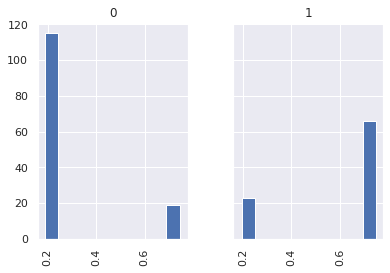

In [ ]:
#Histogram of probability vs actual
dprob = pd.DataFrame(data = {'probability':y_pred_prob, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

ROC curve helps to select a threshold to balance sensitivity and recall.

In [ ]:
#Function to evaluate thresholds of the ROC curve
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

In [ ]:
evaluate_threshold(0.74)

Sensitivity: 0.3146067415730337
Recall: 0.9850746268656716


In [ ]:
evaluate_threshold(0.5)

Sensitivity: 0.7415730337078652
Recall: 0.8805970149253731


By default, the thresdhold to decide a class is 0.5, If we modify it, we should use the new thresdhold.

threshold = 0.8

predicted = model.predict_proba(X) > threshold

AUC is the percentage of the ROC plot underneath the curve. Represents the likelihood that the predictor assigns  a higher predicted probability to the positive observation.  A simple rule  to evaluate a classifier based on this summary value is the following:
* .90-1 = very good (A)
* .80-.90 = good (B)
* .70-.80 = not so good (C)
* .60-.70 = poor (D)
* .50-.60 = fail (F)

In [ ]:
# AUX
print(roc_auc_score(expected, predicted))

0.799890994465873


# Train and Evaluate with K-Fold

This is alternative to splitting the dataset into train and test. It will run k times slower than the other method, but it will be more accurate.

In [ ]:
# This step will take some time
# Cross-validationt
cv = KFold(n_splits=5, shuffle=False, random_state=33)
# StratifiedKFold has is a variation of k-fold which returns stratified folds:
# each set contains approximately the same percentage of samples of each target class as the complete set.
#cv = StratifiedKFold(y, n_folds=3, shuffle=False, random_state=33)
scores = cross_val_score(model, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


ValueError: ignored

We get 78% of success with K-Fold, quite good!

We can plot the [learning curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html). The traning scores decreases with the number of samples. The cross-validation reaches the training score at the end. It seems we will not get a better result with more samples.

In [ ]:
plot_learning_curve(model, "Learning curve with K-Fold", X, y, cv=cv)

# Train and Optimize

In this section we are going to provide an alternative version of the previous one with optimization

In [ ]:
#Tune parameters
gammas = np.logspace(-6, -1, 10)
gs = GridSearchCV(model, param_grid=dict(gamma=gammas))
gs.fit(X_train, y_train)
scores = gs.score(X_test, y_test)
print(scores)

In [ ]:
# Refine model
model = SVC(kernel='linear', gamma=gs.best_estimator_.gamma)
plot_learning_curve(model, "optimized with GridSearch", X, y, cv=cv)

# Visualise

In [ ]:
# Plot with standard configuration of SVM
%run plot_svm
plot_svm(df)

Any value in the blue survived while anyone in the red did not. Checkout the graph for the linear transformation. It created its decision boundary right on 50%! 

# References

* [Titanic Machine Learning from Disaster](https://www.kaggle.com/c/titanic/forums/t/5105/ipython-notebook-tutorial-for-titanic-machine-learning-from-disaster)
* [API SVC scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* [Better evaluation of classification models](http://blog.kaggle.com/2015/10/23/scikit-learn-video-9-better-evaluation-of-classification-models/)

## Licence

The notebook is freely licensed under under the [Creative Commons Attribution Share-Alike license](https://creativecommons.org/licenses/by/2.0/).  

© Carlos A. Iglesias, Universidad Politécnica de Madrid.